In [1]:
import scvelo as scv
import anndata as ad
import scanpy as sc
import pandas as pd
import mygene
from scipy.sparse import csr_matrix, save_npz, load_npz

In [2]:
# from https://github.com/linnykos/veloUncertainty/blob/kevin/code/kevin/Writeup13_greenleaf/Writeup13_scvelo_rna_exploration.ipynb

# Load the sparse matrix
count_matrix = load_npz("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_sparse_counts.npz")
spliced_matrix = load_npz("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_sparse_spliced_counts.npz")
unspliced_matrix = load_npz("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_sparse_unspliced_counts.npz")

In [3]:
#    Assuming `rna_cell_metadata.txt` has rows of cells and columns for metadata,
#    and that one of these columns (likely the index) matches the cell names in `counts.columns`.
cell_metadata = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/rna_cell_metadata.txt", sep='\t', index_col=0)

In [4]:
# Load row and column names
gene_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_gene_names.txt", 
                         header=None)
cell_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_cell_names.txt", 
                         header=None)


spliced_gene_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_spliced_gene_names.txt", 
                         header=None)
spliced_cell_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_spliced_cell_names.txt", 
                         header=None)

unspliced_gene_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_unspliced_gene_names.txt", 
                         header=None)
unspliced_cell_names = pd.read_csv("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/rna_unspliced_cell_names.txt", 
                         header=None)


In [5]:
# Extract gene and cell lists (as Series for convenience)
count_genes = gene_names[0]      # gene_names read from the count matrix file
count_cells = cell_names[0]

spliced_genes = spliced_gene_names[0]
spliced_cells = spliced_cell_names[0]

unspliced_genes = unspliced_gene_names[0]
unspliced_cells = unspliced_cell_names[0]

# Find common genes and cells across all three sets
common_genes = set(count_genes).intersection(spliced_genes, unspliced_genes)
common_cells = set(count_cells).intersection(spliced_cells, unspliced_cells)

# Convert back to lists (or Series) and preserve the original order of the count matrix
common_genes = count_genes[count_genes.isin(common_genes)]
common_cells = count_cells[count_cells.isin(common_cells)]

# We now have ordered lists of genes and cells that are common to all three matrices.

In [6]:
# Next, we need to determine the indices of these common genes and cells in each matrix.
# For each matrix, we know the original rows correspond to genes and columns to cells.

# Create a mapping from gene_name to original row index for each matrix:
count_gene_to_idx = pd.Series(range(count_genes.shape[0]), index=count_genes)
spliced_gene_to_idx = pd.Series(range(spliced_genes.shape[0]), index=spliced_genes)
unspliced_gene_to_idx = pd.Series(range(unspliced_genes.shape[0]), index=unspliced_genes)

# Similarly for cells:
count_cell_to_idx = pd.Series(range(count_cells.shape[0]), index=count_cells)
spliced_cell_to_idx = pd.Series(range(spliced_cells.shape[0]), index=spliced_cells)
unspliced_cell_to_idx = pd.Series(range(unspliced_cells.shape[0]), index=unspliced_cells)

# Get the integer indices for the common genes and cells for each matrix
count_gene_idx = count_gene_to_idx[common_genes].values
count_cell_idx = count_cell_to_idx[common_cells].values

spliced_gene_idx = spliced_gene_to_idx[common_genes].values
spliced_cell_idx = spliced_cell_to_idx[common_cells].values

unspliced_gene_idx = unspliced_gene_to_idx[common_genes].values
unspliced_cell_idx = unspliced_cell_to_idx[common_cells].values

In [7]:
# Now subset each matrix by common genes and cells
# Remember the shape of the matrices should be (n_genes, n_cells) 
# If they are not in that shape (e.g., cells in rows, genes in columns),
# adjust indexing accordingly.

count_matrix_sub = count_matrix[ count_gene_idx[:, None], count_cell_idx ]
spliced_matrix_sub = spliced_matrix[ spliced_gene_idx[:, None], spliced_cell_idx ]
unspliced_matrix_sub = unspliced_matrix[ unspliced_gene_idx[:, None], unspliced_cell_idx ]

# Now all three matrices correspond to the same sets of genes and cells in the same order.
# common_genes and common_cells hold the ordered names.

In [8]:
cell_metadata_sub = cell_metadata.loc[common_cells]

In [9]:
adata = ad.AnnData(
    X=count_matrix_sub.T,
    obs=cell_metadata_sub,
    var=pd.DataFrame(index=common_genes)
)

In [10]:
# 6. Add layers for spliced and unspliced counts
adata.layers["spliced"] = spliced_matrix_sub.T
adata.layers["unspliced"] = unspliced_matrix_sub.T

In [11]:
# Read the cluster names file
cluster_df = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/scRNA_Colors.txt", sep='\t')

In [12]:
# Create a dictionary mapping Cluster.ID (e.g. c0) to Cluster.Name (e.g. nIPC/GluN1)
cluster_map = dict(zip(cluster_df['cluster'], cluster_df['potential name']))

# Now map these to a new column in adata.obs
adata.obs['cluster_name'] = adata.obs['seurat_clusters'].map(cluster_map)

In [13]:
umap_df = pd.read_csv("/home/users/kzlin/kzlinlab/data/greanleaf_brain_multiome/umapModel_rna_hft_uwot.csv", index_col=0)
umap_df.index = cell_names[0]

# Subset umap_df to these cells in the same order as they appear in adata
umap_sub = umap_df.loc[adata.obs_names.intersection(common_cells)]

In [14]:
# Convert to numpy array
adata.obsm["X_umap_greenleaf"] = umap_sub.values

In [15]:
# Define the cell types to keep
cell_types_to_keep = [
    "cycling RG/IPC",
    "radial glia 1 (oRG)",
    "intermediate progenitor",
    "excitatory neuron 1",
    "excitatory neuron 2",
    "excitatory neuron 3",
    "excitatory neuron 6",
    "excitatory neuron 4",
    "excitatory neuron 5",
    "excitatory neuron 7"
]

# Subset the AnnData object
adata = adata[adata.obs["cluster_name"].isin(cell_types_to_keep)].copy()

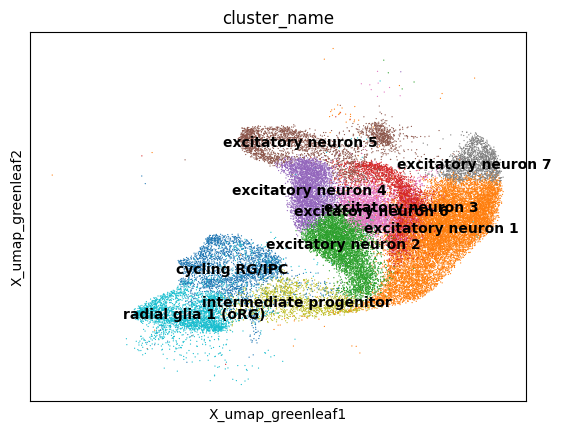

In [16]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="cluster_name",legend_loc="on data")

In [17]:
# Add a placeholder column to adata.var
adata.var["placeholder"] = "NA"  # You can use any default value, like "NA" or None
adata.var.index = adata.var.index.astype(str)
adata.var

,placeholder
0,
ENSG00000243485,NA
ENSG00000237613,NA
ENSG00000186092,NA
ENSG00000238009,NA
ENSG00000239945,NA
...,...
ENSG00000212907,NA
ENSG00000198886,NA
ENSG00000198786,NA


In [23]:
adata.var.index.name = "Ensemble"  
adata.var

,placeholder
Ensemble,
ENSG00000243485,NA
ENSG00000237613,NA
ENSG00000186092,NA
ENSG00000238009,NA
ENSG00000239945,NA
...,...
ENSG00000212907,NA
ENSG00000198886,NA
ENSG00000198786,NA


In [24]:
adata.write("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/kevin/Writeup13/Writeup13_greenleaf_rna_processed.h5ad")

Some summaries

In [25]:
adata

AnnData object with n_obs × n_vars = 38263 × 32648
    obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features', 'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts', 'Ambiguous.Features', 'cluster_name'
    var: 'placeholder'
    uns: 'cluster_name_colors'
    obsm: 'X_umap_greenleaf'
    layers: 'spliced', 'unspliced'

In [26]:
adata.obs['Sample.ID'].value_counts()

Sample.ID
hft_w16_p7_r2    8525
hft_w16_p7_r1    7805
hft_w20_p3_r1    4046
hft_w20_p3_r2    4017
hft_w24_p6_r2    3812
hft_w21_p5_r2    3466
hft_w21_p5_r1    3333
hft_w24_p6_r1    3259
Name: count, dtype: int64

In [27]:
adata.obs['Age'].value_counts()

Age
pcw16    16330
pcw20     8063
pcw24     7071
pcw21     6799
Name: count, dtype: int64

In [28]:
adata.obs['Assay'].value_counts()

Assay
RNA NG    23401
RNA v3    14862
Name: count, dtype: int64

In [37]:
adata.obs['Tissue.ID'].value_counts()

Tissue.ID
HFT7    16330
HFT3     8063
HFT6     7071
HFT5     6799
Name: count, dtype: int64

In [29]:
adata.obs['Batch'].value_counts()

Batch
b2020_03    16330
b2020_02    13870
b2019_06     8063
Name: count, dtype: int64

In [30]:
adata.obs['cluster_name'].value_counts()

cluster_name
excitatory neuron 1        11367
excitatory neuron 2         4984
excitatory neuron 3         3954
excitatory neuron 4         3784
radial glia 1 (oRG)         3155
excitatory neuron 5         2703
cycling RG/IPC              2701
excitatory neuron 6         2685
excitatory neuron 7         1627
intermediate progenitor     1303
Name: count, dtype: int64

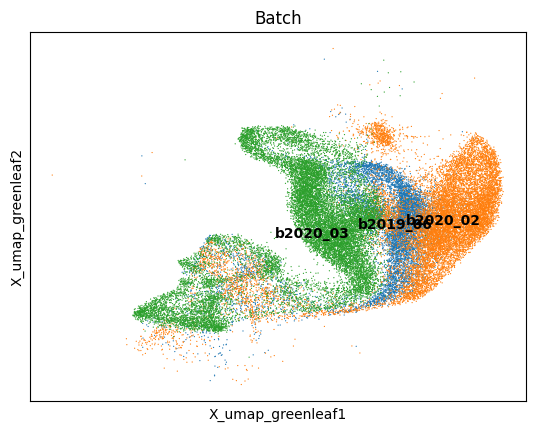

In [31]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="Batch",legend_loc="on data")

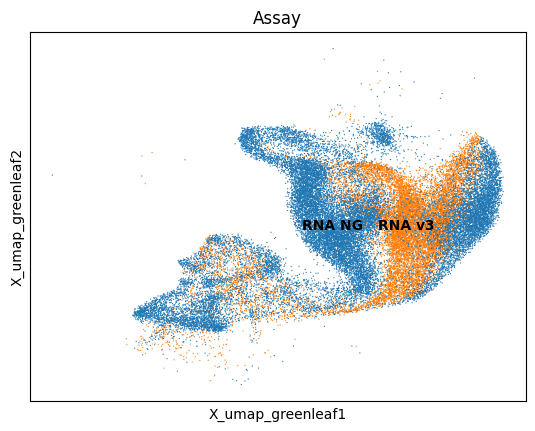

In [32]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="Assay",legend_loc="on data")

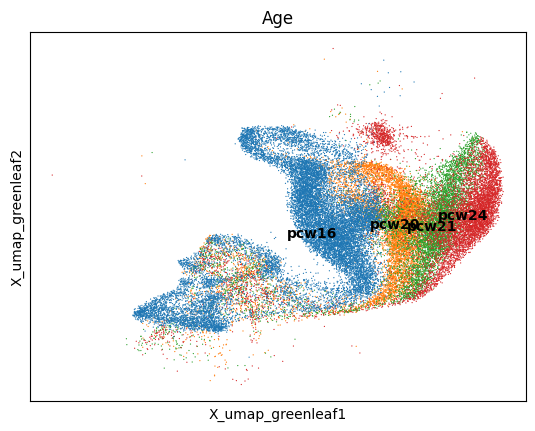

In [33]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="Age",legend_loc="on data")

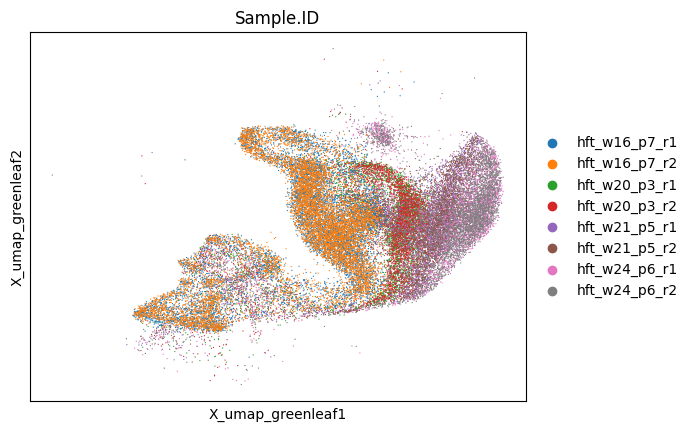

In [36]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="Sample.ID")

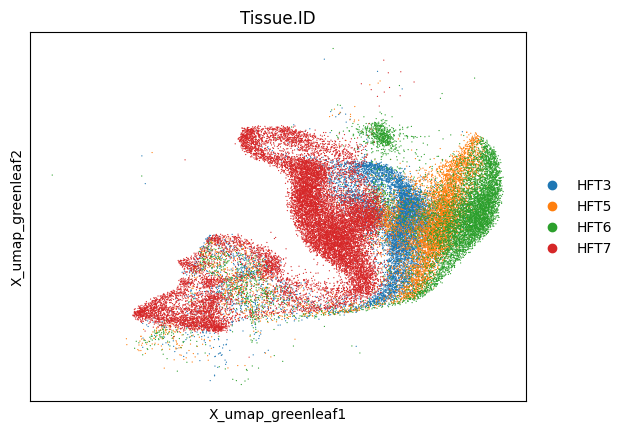

In [38]:
sc.pl.embedding(adata, basis="X_umap_greenleaf", color="Tissue.ID")